## 자동 미분 및 그래디언트

* 자동 미분: 역전파 알고리즘과 같은 머신러닝 알고리즘 구현에 유용

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## 그래디언트 계산하기

자동으로 미분하기 위해 Tensorflow는 정방향 패스동안 어떤 연산이 어떤 순서로 발생했는지 기억해야 함

그리고 역방향 패스동안 Tensorflow는 이 연산 목록을 역순으로 이동하여 그래디언트 계산

## 그래디언트 테이프

* tf.GradientTape API : 자동 미분을 위한 API 제공


* `tf.GradientTape`
    - 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 기록
    - 후진 방식 자동 미분(reverse mode differentitation)을 사용해 테이프에 기록된 연산의 그래디언트 계산

In [2]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

`GradientTape.gradient(target, sources)`

- 일부 소스(종종 모델 변수)에 상대적인 일부 대상(종종 손실)의 그래디언트를 계산
- 모든 텐서에서 쉽게 작동

In [3]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [4]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)

두 변수 모두에게 loss의 그래디언트를 가져오려면, 두 변수를 gradient 메서드에 소스로 전달 가능

테이프는 소스가 전달되는 방식에 대해 융통성이 있으며, 목록 또는 사전의 중첩된 조합을 허용하고 같은 방식으로 구조화된 그래디언트를 반환함

In [5]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

In [6]:
# 각 소스에 대한 그래디언트는 소스의 형상을 가짐
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [7]:
# 그래디언트 계산: 변수의 사전을 전달
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-4.2609806,  2.4636304], dtype=float32)>

## 모델에 대한 그래디언트

`tf.Module`

- 검사점 설정 및 내보내기를 위해 `tf.Variable`을 수집
- 모든 서브 클래스는 `Module.trainable_variables` 속성에서 변수를 집계, 몇 줄의 코드로 그래디언트 계산 가능

In [8]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
    # Forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [9]:
for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


## 테이프의 감시 대상 제어하기

기본 동작은 훈련 가능한 `tf.Variable`에 엑세스한 후, 모든 연산을 기록하는 것

왜 기록해야 할까?

- 테이프는 역방향 패스의 그래디언트를 계산하기 위해 정방향 패스 기록할 연산을 알아야 함
- 테이프는 중간에 대한 참조를 보유하므로 불필요한 연산을 기록하지 않음
- 가장 일반적인 예: 모든 모델의 훈련 가능 가능한 변수에 대해 손실 그래디언트를 계산하는 것

##### (예) tf.Tensor가 기본적으로 감시되지 않고, tf.Variable을 훈련할 수 없어 그래디언트 계산 못함

In [10]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
    print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


`GradientTape.watched_variables` : 메서드를 사용하여 테이프에서 감시중인 변수 나열 가능

In [11]:
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` : 사용자가 감시 대상 또는 감시 예외 대상 제어할 수 있는 후크 제공

`GradientTape.watch(x)` : tf.Tensor에 대한 그래디언트 기록을 위해 호출

In [12]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


`watch_accessed_variables=False`: 모든 `tf.Variables`을 감시하는 기본 동작 비활성화 하기 위해 사용

In [13]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)

x0에서 `GradientTape.watch`가 호출되지 않았으므로, 그래디언트가 계산되지 않음

In [14]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## 중간 결과

`tf.GradientTape` : 컨텍스트 내에서 계산된 중간값과 관련하여, 출력의 그래디언트 요청할 수도 있음

In [15]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


`GradientTape.gradient` 메서드 호출 -> GradientTape가 보유한 리소스 해제

동일한 계산에 대해 여러 그래디언트를 계산하려면 `persistent=True` 그래디언트 테이프를 만듦 <br>
그러면, 리소스 해제될 때 gradient 메서드 여러 번 호출 가능

In [16]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [17]:
del tape   # Drop the reference to the tape

## 성능에 대한 참고 사항

- 그래디언트 테이프 컨텍스트 내 연산 수행 : 작은 오버헤드 존재 -> 필요한 경우만 사용


- 그래디언트 테이프는 메모리를 사용하여 역방향 패스동안 사용하기 위해 입출력을 포함한 중간 결과까지 저장
    - 효율성을 위해(ReLU와 같은) 일부 연산은 중간 결과를 유지할 필요가 없으며 정방향 패스 동안 정리
    - But, `persistent=True`를 사용하면, 아무것도 삭제되지 않아 최대 메모리 사용량 높아짐

## 스칼라가 아닌 대상의 그래디언트

그래디언트는 기본적으로 스칼라에 대한 연산

In [18]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
    y0 = x**2
    y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


따라서, 여러 대상의 그래디언트 요청 시 각 소스의 결과는 다음과 같음 

- 대상의 합계 또는 그에 상응하는 그래디언트
- 각 대상의 그래디언트의 합계

In [19]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y0 = x**2
    y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


대상이 스칼라가 아닌 경우, 합계의 그래디언트로 계산

In [20]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
    y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


이렇게 하면, 손실 컬렉션 합계의 그래디언트 또는 요소별 손실 계산 합계의 그래디언트를 간단하게 구현할 수 있음

- 각 항목에 대해 별도의 그래디언트가 필요한 경우, 야고비안 참조

In [21]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

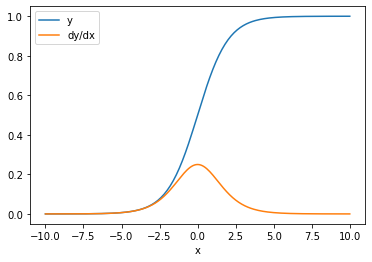

In [22]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## 흐름 제어하기

그래디언트 테이프 : 실해오디는 연산을 기록하므로, Python 제어 흐름이 자연스럽게 처리됨

여기서는 if의 각 분기에 서로 다른 변수가 사용됨. 그래디언트는 사용된 변수에만 연결

In [23]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


제어문 자체는 미분할 수 없으므로, 그래디언트 기반 최적화 프로그램에는 보이지 않음

위 예제에서 x 값에 따라 테이프는 result = v0 또는 result = v1**2를 기록 <br>
x에 대한 그래디언트는 항상 None

In [24]:
dx = tape.gradient(result, x)

print(dx)

None


## gradient가 None을 반환하는 경우

대상이 소스와 연결되어 있지 않으면 gradient가 None을 반환

In [25]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y * y
print(tape.gradient(z, x))

None


### 그래디언트의 연결을 끊을 수 있는 몇 가지 덜 명확한 방법 4가지

### 1. 변수가 텐서로 대체

한 가지 일반적인 오류: `Variable.assign`을 사용하여 `tf.Variable`을 업데이트하는 대신, <br>
실수로 `tf.Variable`을 `tf.Tensor`로 대체하는 것

In [26]:
x = tf.Variable(2.0)

for epoch in range(2):
    with tf.GradientTape() as tape:
        y = x+1

    print(type(x).__name__, ":", tape.gradient(y, x))
    x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. TensorFlow 외부에서 계산

계산에서 TensorFlow를 종료하면 테이프가 그래디언트 경로 기록 불가능

In [27]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
    x2 = x**2

    # This step is calculated with NumPy
    y = np.mean(x2, axis=0)

    # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
    # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3. 정수 또는 문자열을 통해 그래디언트를 구함

정수와 문자열은 구별할 수 없음. dtype을 지정하지 않으면, 실수로 int 상수 또는 변수를 만들기 쉬움

In [28]:
x = tf.constant(10)

with tf.GradientTape() as g:
    g.watch(x)
    y = x * x

print(g.gradient(y, x))

None


TensorFlow는 유형 간에 자동으로 전송되지 않으므로, 실제로 그래디언트가 누락되는 대신 유형 오류 발생

### 4. 상태 저장 개체를 통해 그래디언트를 구함

상태가 그래디언트를 중지함. 상태 저장 객체에서 읽을 때, 테이프는 현재 상태만 볼 수 있음 (기록 X)

`tf.Tensor`는 변경할 수 없음. 텐서가 작성된 후에는 변경할 수 없음. 값은 있지만 상태는 X. 지금까지 논의된 모든 연산은 상태 비저장

`tf.matmul`의 출력은 입력에만 의존

`tf.Variable`은 내부 상태와 값을 가짐. 변수를 사용하면 상태를 읽음. 변수와 관련하여 그래디언트를 계산하는 것이 일반적이지만, 변수의 상태는 그래디언트 계산이 더 멀리 돌아가지 않도록 차단함

`tf.data.Dataset` 반복기(iterator)와 `tf.queue`는 상태 저장이며, 이들을 통과하는 텐서의 모든 그래디언트를 중지함

In [29]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
    # Update x1 = x1 + x0.
    x1.assign_add(x0)
    # The tape starts recording from x1.
    y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


## 그래디언트가 등록되지 않음

`tf.Operation`: 미분 불가능한 것으로 등록되어 None 을 반환, 다른 연산엔 그래디언트 등록 안됨

`tf.raw_ops` : 그래디언트가 등록된 저수준 op가 표시

그래디언트가 등록되지 않은 float op를 통해, 그래디언트를 얻고자 시도하면 테이프가 자동으로 None을 반환하는 대신 오류가 발생

예를 들어, `tf.image.adjust_contrast` 함수는 그래디언트를 가질 수 있지만, 그래디언트는 구현되지 않은 `raw_ops.AdjustContrastv2`를 래핑함

이 op를 미분해야 하는 경우, `tf.RegisterGradient`를 사용하여 그래디언트를 구현하고, 등록하거나 다른 ops를 사용하여 함수를 다시 구현해야 함

In [30]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)

try:
    print(tape.gradient(new_image, [image, delta]))
    assert False   # This should not happen.
except LookupError as e:
    print(f'{type(e).__name__}: {e}')

LookupError: gradient registry has no entry for: AdjustContrastv2


## None 대신 0

연결되지 않은 그래디언트의 경우, None 대신 0을 가져오는 것이 편리한 경우가 있음

연결되지 않은 그래디언트가 있을 때, `unconnected_gradients` 인수를 사용하여 반환할 항목 결정 가능

In [31]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
    z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
